In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Import csv file

In [3]:
df_train = pd.read_csv('train.csv', sep='|')
df_test = pd.read_csv('test.csv', sep='|')

### check that data types are correctly imported

In [4]:
df_train.dtypes

trustLevel                     int64
totalScanTimeInSeconds         int64
grandTotal                   float64
lineItemVoids                  int64
scansWithoutRegistration       int64
quantityModifications          int64
scannedLineItemsPerSecond    float64
valuePerSecond               float64
lineItemVoidsPerPosition     float64
fraud                          int64
dtype: object

In [5]:
df_test.dtypes

trustLevel                     int64
totalScanTimeInSeconds         int64
grandTotal                   float64
lineItemVoids                  int64
scansWithoutRegistration       int64
quantityModifications          int64
scannedLineItemsPerSecond    float64
valuePerSecond               float64
lineItemVoidsPerPosition     float64
dtype: object

### check distribution of target variable 'fraud'

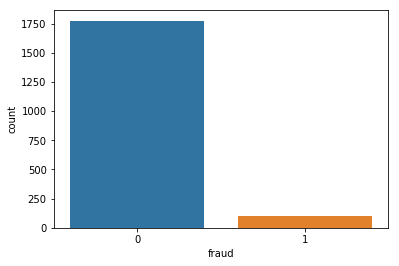

In [6]:
sns.countplot(df_train['fraud'])

In [7]:
sum(df_train['fraud'] == 1)/len(df_train)

0.05534858967535923

- target variable is imabalanced, only 5.53% of the observations are classified as 'fraud'
- this is in line with the 5% from the task description

### create new features
__scannedLineItemsTotal__
- scannedLineItemsTotal = scannedLineItemsPerSecond * totalScanTimeInSeconds
- total number of scanned products

In [8]:
df_train['scannedLineItemsTotal'] = df_train['scannedLineItemsPerSecond'] * df_train['totalScanTimeInSeconds']
df_test['scannedLineItemsTotal'] = df_test['scannedLineItemsPerSecond'] * df_test['totalScanTimeInSeconds']

__valuePerLineItem__
- valuePerLineItem = grandTotal / scannedLineItemsTotal
- average value per product

In [9]:
df_train['valuePerLineItem'] = df_train['grandTotal'] / df_train['scannedLineItemsTotal']
df_test['valuePerLineItem'] = df_test['grandTotal'] / df_test['scannedLineItemsTotal']

__quantityModificationsPerLineItem__
- quantityModificationsPerLineItem = quantityModifications / scannedLineItemsTotal
- average number of quantity modifications per product

In [10]:
df_train['quantityModificationsPerLineItem'] = df_train['quantityModifications'] / df_train['scannedLineItemsTotal']
df_test['quantityModificationsPerLineItem'] = df_test['quantityModifications'] / df_test['scannedLineItemsTotal']

### sanity checks
- lineItemVoids / scannedLineItemsTotal == lineItemVoidsPerPosition

In [11]:
x = round(df_train['lineItemVoids']/df_train['scannedLineItemsTotal'],10)
y = round(df_train['lineItemVoidsPerPosition'],10)
sum(x == y)/len(x)

1.0

## correlation matrix
### standard correlation matrix

In [12]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,scannedLineItemsTotal,valuePerLineItem,quantityModificationsPerLineItem
trustLevel,1,0.0252642,0.0476556,-0.0173116,0.0172955,0.00650646,0.0307012,0.0276263,0.00924119,-0.319765,0.00635698,0.00827033,0.00151577
totalScanTimeInSeconds,0.0252642,1,-0.00122992,0.0190679,0.009066,-0.0114146,-0.262988,-0.20845,-0.0116229,0.110414,0.00976949,-0.0194337,-0.0285975
grandTotal,0.0476556,-0.00122992,1,0.00632097,-0.0305731,-0.00816274,-0.0118848,0.0756791,-0.00885837,0.00142089,-0.00695467,0.328316,-0.00488355
lineItemVoids,-0.0173116,0.0190679,0.00632097,1,-0.0170233,-0.00717288,-0.00443802,0.00511437,0.346514,0.0634963,0.0216469,-0.0257316,-0.0161964
scansWithoutRegistration,0.0172955,0.009066,-0.0305731,-0.0170233,1,0.0189605,-0.0241256,-0.0188444,0.00283393,0.0741225,-0.0265285,0.00297544,0.00396155
quantityModifications,0.00650646,-0.0114146,-0.00816274,-0.00717288,0.0189605,1,-0.0148799,0.0105484,0.0183183,-0.000863773,-0.0355705,0.0141949,0.368689
scannedLineItemsPerSecond,0.0307012,-0.262988,-0.0118848,-0.00443802,-0.0241256,-0.0148799,1,0.692152,-0.0563164,-0.0230853,0.100724,-0.0615867,-0.0558924
valuePerSecond,0.0276263,-0.20845,0.0756791,0.00511437,-0.0188444,0.0105484,0.692152,1,0.0198865,-0.0288727,-0.0223956,0.0330833,0.0403772
lineItemVoidsPerPosition,0.00924119,-0.0116229,-0.00885837,0.346514,0.00283393,0.0183183,-0.0563164,0.0198865,1,-0.0901164,-0.519169,0.610629,0.616196
fraud,-0.319765,0.110414,0.00142089,0.0634963,0.0741225,-0.000863773,-0.0230853,-0.0288727,-0.0901164,1,0.298423,-0.100765,-0.0943931


### absolute correlation between fraud and all other features

In [13]:
corr_abs = abs(df_train.corr())
corr_abs[['fraud']].style.background_gradient(cmap='coolwarm')

,fraud
trustLevel,0.319765
totalScanTimeInSeconds,0.110414
grandTotal,0.00142089
lineItemVoids,0.0634963
scansWithoutRegistration,0.0741225
quantityModifications,0.000863773
scannedLineItemsPerSecond,0.0230853
valuePerSecond,0.0288727
lineItemVoidsPerPosition,0.0901164
fraud,1


- _trustLevel_ and the new feature _scannedLineItemsTotal_ are quite correlated with the target variable
- the other two new features _valuePerLineItem_ and _quantitiyModificationsPerLineItem_ have a moderate correlation with the target variable
  - However, we should be careful, as their correlation might only come from the fact that they are created using _scannedLineItemsTotal_
- other features that might be interesting based on the correlation are:
  - _totalScanTimeInseconds_
  - _lineItemVoids_
  - _scansWithoutRegistration_
  - _lineItemVoidsPerPosition_

## for each feature compare histograms of fraud and noFraud

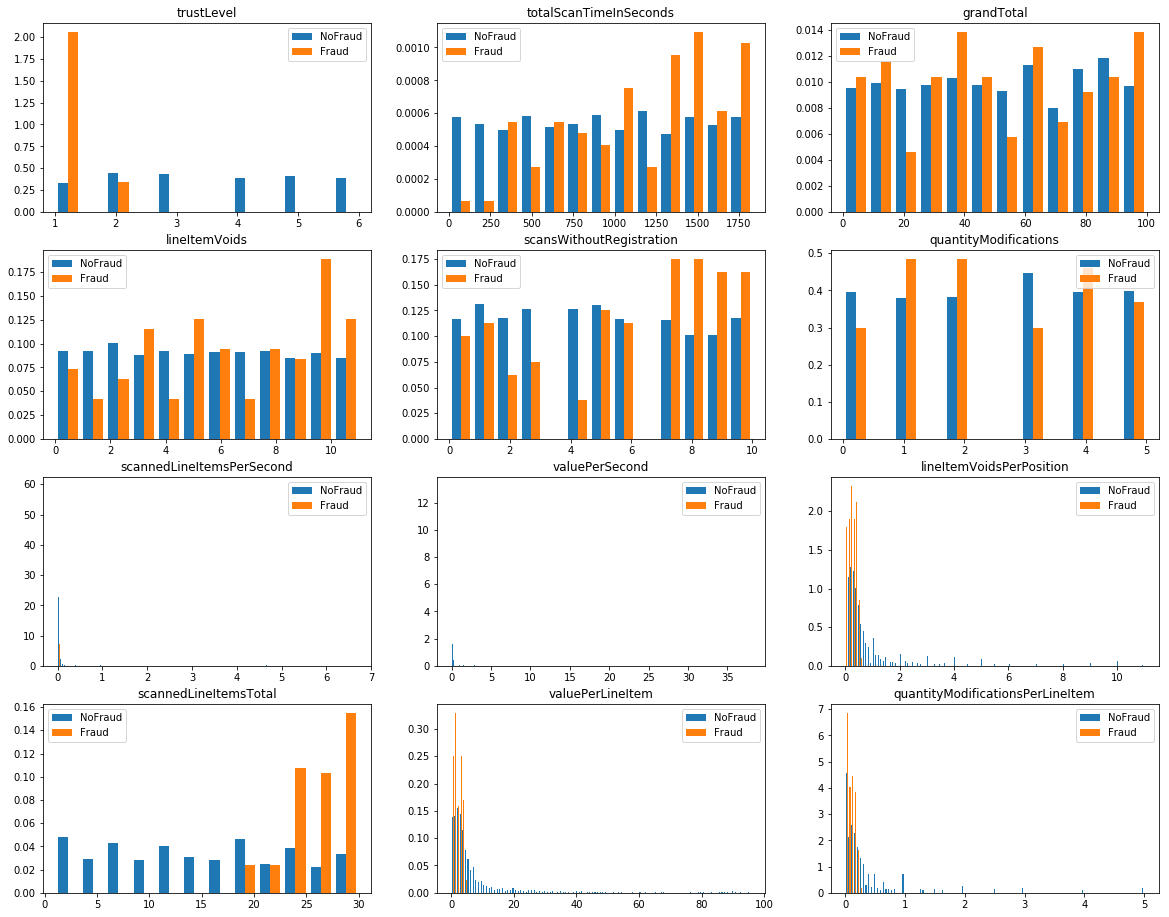

In [14]:
features = df_train.columns[df_train.columns != 'fraud']
numberOfRows = math.ceil(len(features) / 3)

plt.figure(figsize=(20,numberOfRows*4))
labels=['NoFraud','Fraud']
i = 1
for f in features:
    plt.subplot(numberOfRows, 3, i)
    featureNoFraud = df_train[f].loc[df_train['fraud'] == 0]
    featureFraud = df_train[f].loc[df_train['fraud'] == 1]
    plt.hist([featureNoFraud,featureFraud], bins='auto',density=True, label=labels)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f)
    i+=1

- it is very interesting to see that _fraud_ occurs only in _trustLevel_ 1 and 2
- additonally _fraud_ only occurs for observations where _scannedLineItemsTotal_ is above 20
- we should investigate if it makes sense to remove outliers for some features
- interestingly most of the outliers seem to be non _fraud_ cases

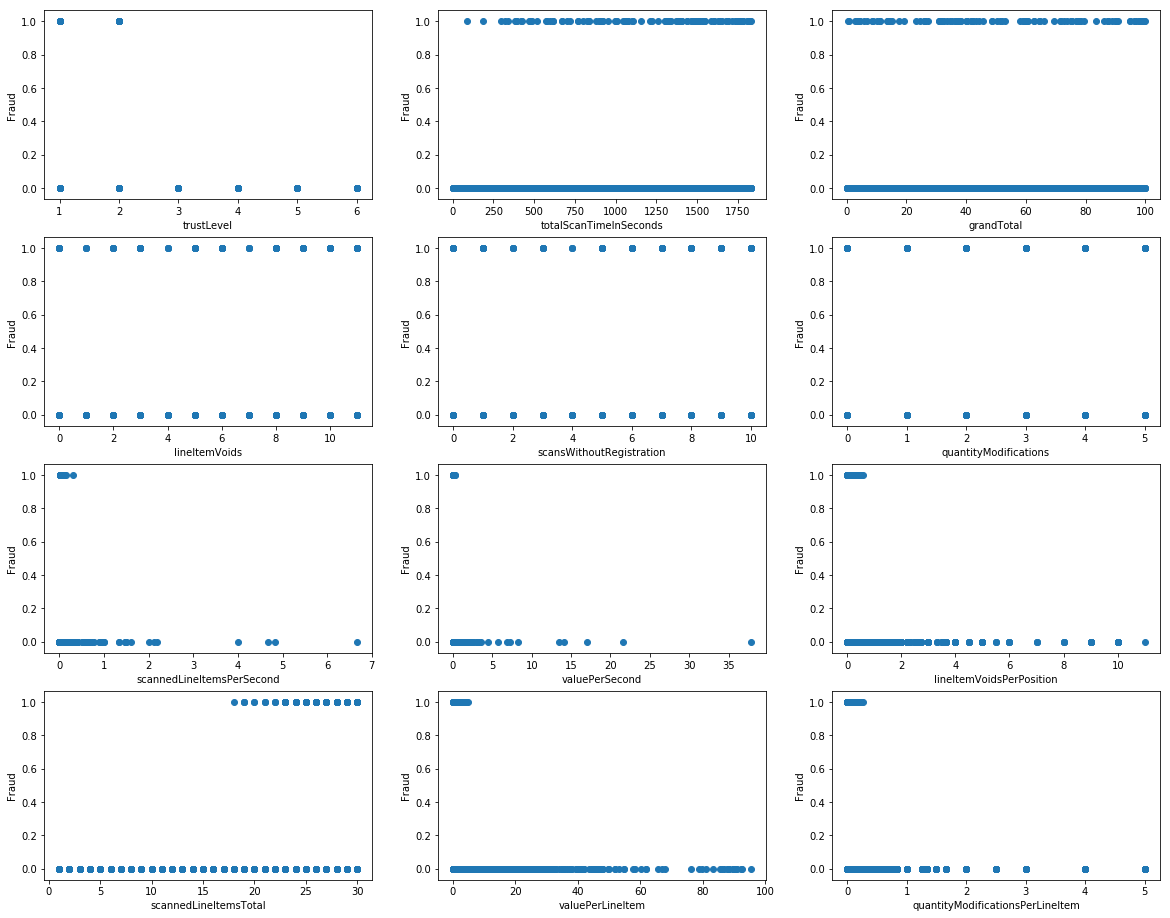

In [22]:
## added by patrick

features = df_train.columns[df_train.columns != 'fraud']
numberOfRows = math.ceil(len(features) / 3)

plt.figure(figsize=(20,numberOfRows*4))
labels=['NoFraud','Fraud']
i = 1
for f in features:
    plt.subplot(numberOfRows, 3, i)
    plt.scatter(df_train[f], df_train['fraud'])
    plt.xlabel(f)
    plt.ylabel("Fraud")
    #plt.title(f)
    i+=1

### Look again at some features after removing possible outliers

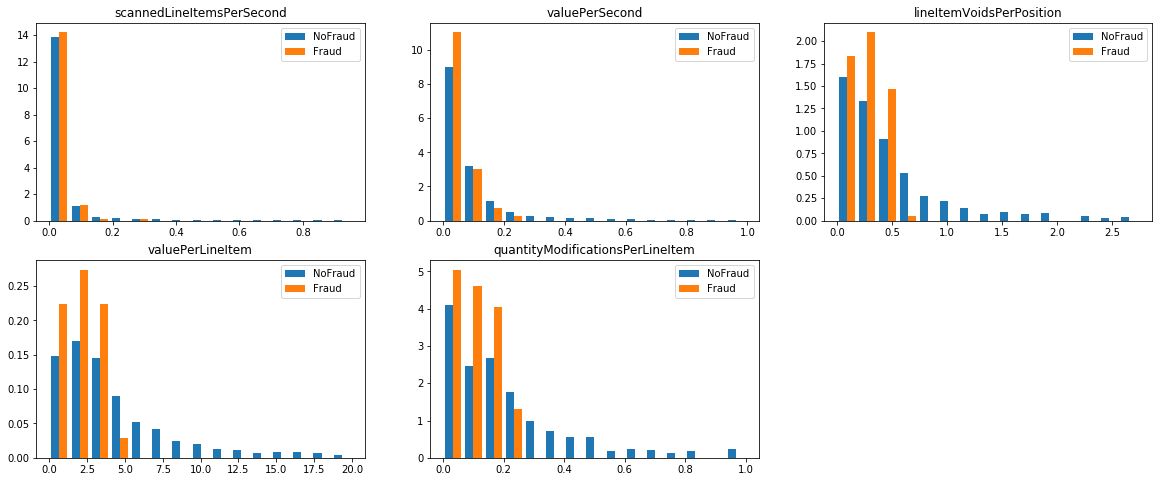

In [16]:
# Create dictionary of the form (key: [outlier threshold, number of bins])
featuresNoOutlier = {'scannedLineItemsPerSecond': [1,15],
                     'valuePerSecond': [1,15],
                     'lineItemVoidsPerPosition': [3,15],
                     'valuePerLineItem': [20,15],
                     'quantityModificationsPerLineItem': [1,15]}
numberOfRows = math.ceil(len(featuresNoOutlier) / 3)

plt.figure(figsize=(20,numberOfRows*4))
labels=['NoFraud','Fraud']
i = 1
for f, value in featuresNoOutlier.items():
    plt.subplot(numberOfRows, 3, i)
    indicator = df_train[f] < value[0]
    featureNoFraud = df_train[f][indicator].loc[df_train['fraud'][indicator] == 0]
    featureFraud = df_train[f][indicator].loc[df_train['fraud'][indicator] == 1]
    plt.hist([featureNoFraud,featureFraud], bins=value[1],density=True, label=labels)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f)
    i+=1

- _valuePerLineItem_ seems to be lower on average for _fraud_
- overall, most of the features behave at least a little bit different for _fraud_ and non _fraud_

## for each feature compare histograms of train and test

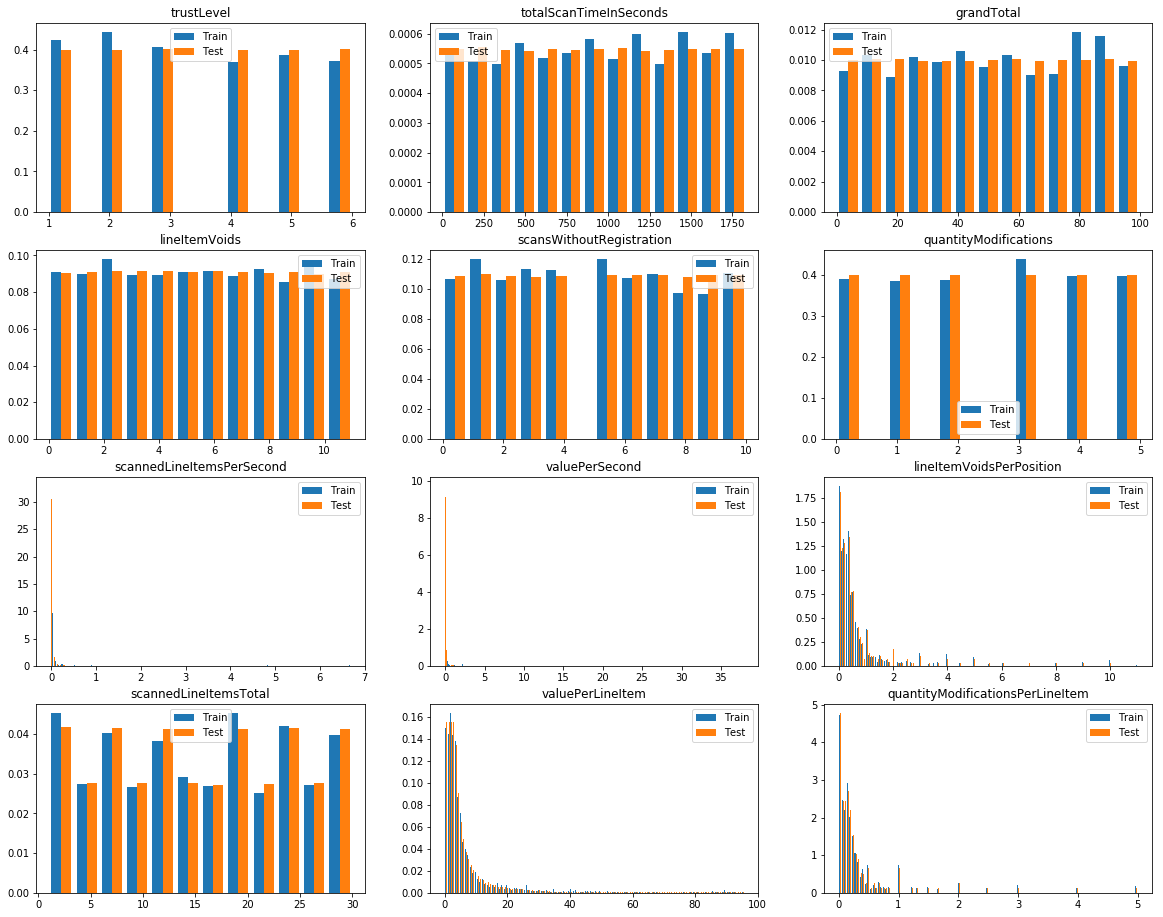

In [17]:
numberOfRows = math.ceil(len(features) / 3)
plt.figure(figsize=(20,numberOfRows*4))
labels=['Train','Test']
i = 1
for f in features:
    plt.subplot(numberOfRows, 3, i)
    plt.hist([df_train[f],df_test[f]], bins='auto',density=True, label=labels)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f)
    i+=1

### Look again at some features after removing possible outliers

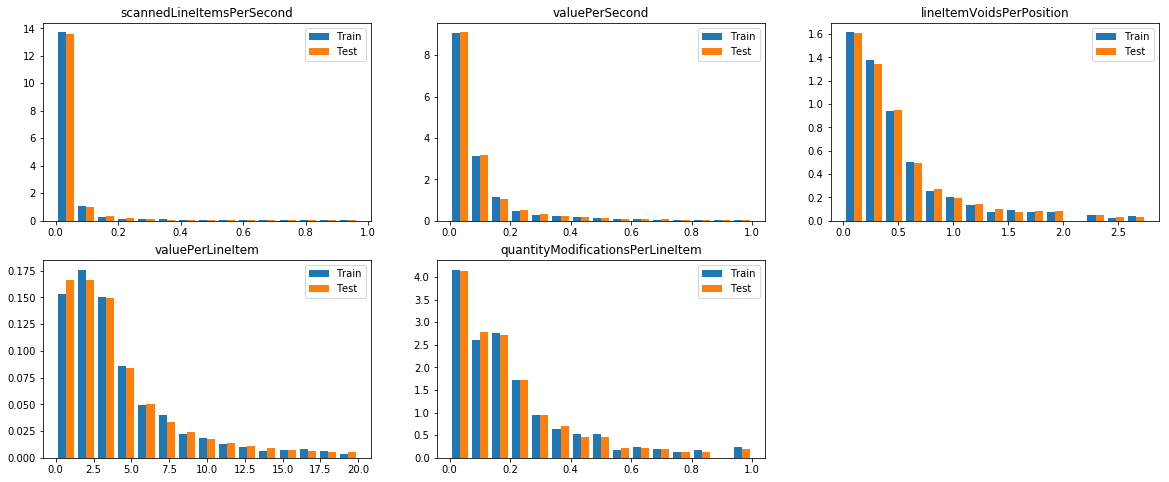

In [18]:
# Create dictionary of the form (key: [outlier threshold, number of bins])
featuresNoOutlier = {'scannedLineItemsPerSecond': [1,15],
                     'valuePerSecond': [1,15],
                     'lineItemVoidsPerPosition': [3,15],
                     'valuePerLineItem': [20,15],
                     'quantityModificationsPerLineItem': [1,15]}
numberOfRows = math.ceil(len(featuresNoOutlier) / 3)

plt.figure(figsize=(20,numberOfRows*4))
labels=['Train','Test']
i = 1
for f, value in featuresNoOutlier.items():
    plt.subplot(numberOfRows, 3, i)
    indicatorTrain = df_train[f] < value[0]
    indicatorTest = df_test[f] < value[0]
    plt.hist([df_train[f].loc[indicatorTrain],df_test[f].loc[indicatorTest]], bins=value[1],density=True, label=labels)
    plt.legend()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f)
    i+=1

- Distributions of the test set and the training set seem to be similar